In [1]:
using DifferentialEquations, ParameterizedFunctions
using Plots, Colors
using LaTeXStrings
using Distributions
#Used for loading Phys data
using PyCall
pyABF = pyimport("pyabf")
using StaticArrays

In [2]:
include("RetinalChaos.jl");

┌ Warning: Symbolic calculations could not initiate. Likely there's a function which is not differentiable by SymEngine.
└ @ ParameterizedFunctions C:\Users\mtarc\.julia\packages\ParameterizedFunctions\WcTrd\src\ode_def_opts.jl:244


In [3]:
using Plots.Measures
font_title = Plots.font("Arial", 24)
font_axis = Plots.font("Arial", 12)
font_legend = Plots.font("Arial", 8)
pyplot(titlefont=font_title, guidefont = font_axis, legendfont = font_legend)

Plots.PyPlotBackend()

# RetinalChaos.jl: An introduction
### In order to understand the code published here, these notebooks will act as simple tutorials on both how the model was designed. 

## Table of contents:

### [1] Introduction, Motivation, and Components
#### [1.1] Voltage and Potassium gating components of the model
#### [1.2] Calcium and the Biochemical Reactions of the sAHP
#### [1.3] Acetylcholine Diffusion and Dynamics
#### [1.4] Gaussian White noise and dynamics

### _**[2] Analyzing Data Output of the model**_
#### [2.1] Dynamical Analysis
#### **[2.2] Fitting Experimental Data (Patch)**
#### [2.3] Fitting Experimental Data (Multi-electrode array)
#### [2.4] Fitting Experimental Data (Calcium Imageing) 

### [3] Experiments
#### [3.1] Dual Eye Correlations
#### [3.2] Recapitulations of older papers

# Just to recap the model in full is 
\begin{align}
   C_m\frac{dV}{dt} &= I_{leak} + I_{Ca} + I_K + I_{app} + I_{noise}\\
   \tau_N\frac{dN}{dt} &= \Lambda(V)(N_\infty(V) - N)\\
   \tau_C\frac{d[Ca^{2+}]}{dt} &= C_0 + \delta I_{Ca}(V) -\lambda  [Ca^{2+}]\\
   \tau_a\frac{da}{dt} &= \alpha * [Ca^{2+}]^4 * \left(1- a\right) - a\\
   \tau_b\frac{db}{dt} &= \beta * a^4 * (1 - b) - b\\
   \tau_{[ACh]}\frac{d[ACh]}{dt} &=  \nabla_{xx}^2 [ACh] + \rho \Phi(V) -[ACh]
\end{align}


### Optimizing current Models

- We have so far established a acceptable model to characterize the neuronal firing of starburst amacrine cells. 
- Our goal is to optimize the model according to 4 characteristics. 
    - 1) Patch Clamp from isolated Starburst amacrine cells
    - 2) Patch clamp from Starburst amacrine cells within a lattice of neurons
    - 3) Multi-electrode array recordings
    - 4) Calcium Imaging recordings
- With each kind of experimental data we can make predictions about the model

### Loading Physiological Data from .abf files

In [4]:
target_folder = "D:\\2019_Renna Lab\\Data\\Patching\\"
target_file = "D:\\2019_Renna Lab\\Data\\Patching\\2019_11_03_Patch\\Animal_2\\Cell_3\\19n03042.abf"

"D:\\2019_Renna Lab\\Data\\Patching\\2019_11_03_Patch\\Animal_2\\Cell_3\\19n03042.abf"

In [5]:
#Load experimental data
exp_data = pyABF.ABF(target_file)
#Extract the time trace, and the 
t = exp_data.sweepX
dt = t[2]
v_offset = -15.0

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\mtarc\.julia\packages\PyCall\ttONZ\src\pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('ABF file does not exist: D:\\2019_Renna Lab\\Data\\Patching\\2019_11_03_Patch\\Animal_2\\Cell_3\\19n03042.abf')
  File "C:\Users\mtarc\Anaconda3\envs\RetinalWaves\lib\site-packages\pyabf\abf.py", line 72, in __init__
    raise ValueError("ABF file does not exist: %s" % self.abfFilePath)


In [6]:
exp_data.setSweep(sweepNumber = 0, channel = 0);
vm = exp_data.sweepY;
reduced = round.(Int, LinRange(Int(130/dt), Int(230/dt), Int(100e3)));
#reduced = round.(Int, LinRange(Int(130/dt), Int(230/dt), Int(100e3)));
t_offset = (t[reduced] .- t[reduced][1]).*1000;
dt_sim = round(Int, t_offset[2]-t_offset[1])

UndefVarError: UndefVarError: exp_data not defined

In [7]:
histogram(vm[reduced])

UndefVarError: UndefVarError: vm not defined

In [8]:
p_dict = read_JSON("params.json", is_type = Dict{Symbol, Float64});
u_dict = read_JSON("conds.json", is_type = Dict{Symbol, Float64});
#If you want to see the effects of diffusion then adjust D
p_dict[:σ] = 0.1
p_dict[:τw] = 1000.0  
p_dict[:I_app] = 0.0

0.0

In [9]:
p0 = map(x -> Float64(p_dict[x]), BurstModel.params);
u0 = map(x -> Float64(u_dict[x]), BurstModel.syms);
tspan = (0.0, 300e3);
SDEprob = SDEProblem(BurstModel, noise, u0, tspan, p0)
println("Time it took to simulate 200ms:")
@time sol = solve(SDEprob, SOSRI(), abstol = 2e-2, reltol = 2e-2,  maxiters = 1e7, saveat = dt_sim);

Time it took to simulate 200ms:


UndefVarError: UndefVarError: dt_sim not defined

In [10]:
##Plotting this is expensive, so don't do it often
xlims = (0, t_offset[end])
ellapsed_time = (xlims[end]-xlims[1])/1000
dt_lims = 5e3
xticks = (collect(xlims[1]:dt_lims:xlims[2]), collect(0:(dt_lims/1000):ellapsed_time))
ylims = (-90.0, 0.0)
yticks = (collect(ylims[1]:5:ylims[2]))

p = plot(xlabel = "time (s)", ylabel = "membrane voltage (mV)")
plot!(p, sol, vars = [:v], label = "Model data", 
    lw = 2.0, c = :blue)
plot!(p, t_offset, vm[reduced].+v_offset, label = "Experimental Data", 
    lw = 2.0, c = :green,
    xlims = xlims, xticks = xticks, 
    ylims = ylims, yticks = yticks
)

UndefVarError: UndefVarError: t_offset not defined

# Fitting the model

#### Lagged Mean Square Error
##### Each time series has $t$ time points. Each $t$ will be offset and the mean squared error will be calculated from that. The best mean square error will be recorded and this is the lagged loss of the time series. 

In [13]:
Ŷ = map(t -> sol(t)[1], sol.t)
Y = vm[reduced].+v_offset
old_rng = (minimum(Y), maximum(Y))
f_norm(x) = normalize(x; old_rng = old_rng)
Ŷ_norm = Ŷ |> f_norm;
Y_norm = Y |> f_norm;

In [14]:
min_loss, lag = lagged_loss(Ŷ_norm, Y_norm, weights = [1.0, 10.0])

(16.58555636722266, 54000.0)

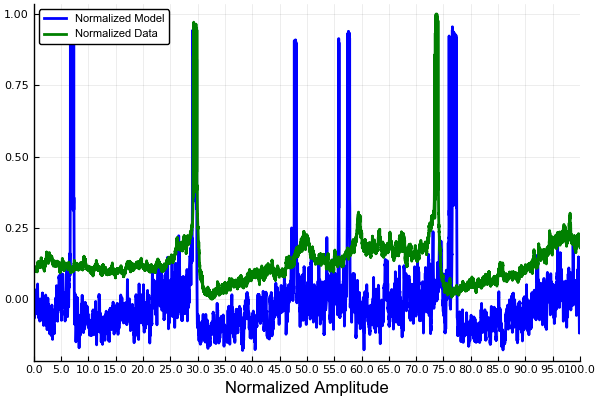

In [15]:
i = lag
fit_rng = Int.(collect(i:(t_offset[end]+i-1)))
p = plot()
plot!(p, Ŷ_norm[fit_rng], c = :blue, lw = :2.0, label = "Normalized Model")
plot!(p, Y_norm, c = :green, lw = :2.0, label = "Normalized Data",
    xlims = xlims, xticks = xticks
)
xlabel!(p, "Normalized Amplitude")

### Monte Carlo Approach to fitting 

In [110]:
p_dict = read_JSON("params.json", is_type = Dict{Symbol, Float64});
u_dict = read_JSON("conds.json", is_type = Dict{Symbol, Float64});

In [111]:
p0 = map(x -> Float64(p_dict[x]), BurstModel.params);
u0 = map(x -> Float64(u_dict[x]), BurstModel.syms);
tspan = (0.0, 300e3);
prob = SDEProblem(BurstModel, noise, u0, tspan, p0)
println("Time it took to simulate 200ms:")
@time sol = solve(prob, SOSRA(), abstol = 2e-2, reltol = 2e-2, maxiters = 1e7, saveat = dt_sim);

Time it took to simulate 200ms:
  2.189659 seconds (19.11 M allocations: 402.116 MiB, 2.21% gc time)


In [112]:
dists = create_distributions(BurstModel.params, p0; std = 0.01)
#write_JSON(dists, "dists.json")

Dict{Symbol,Tuple} with 32 entries:
  :V1     => (-20.0, 0.2, -Inf, 0.0)
  :V2     => (20.0, 0.2, 0.0, Inf)
  :E_Ca   => (40.0, 0.4, 0.0, Inf)
  :g_K    => (5.0, 0.05, 0.0, Inf)
  :g_TREK => (2.0, 0.02, 0.0, Inf)
  :g_leak => (2.0, 0.02, 0.0, Inf)
  :τc     => (2000.0, 20.0, 0.0, Inf)
  :α      => (62.5, 0.625, 0.0, Inf)
  :D      => (0.01, 0.0001, 0.0, Inf)
  :V4     => (7.0, 0.07, 0.0, Inf)
  :τa     => (8300.0, 83.0, 0.0, Inf)
  :V0     => (-40.0, 0.4, -Inf, 0.0)
  :σ      => (8.0, 0.08, 0.0, Inf)
  :τACh   => (540.0, 5.4, 0.0, Inf)
  :k_d    => (0.05, 0.0005, 0.0, Inf)
  :λ      => (2.702, 0.02702, 0.0, Inf)
  :C_m    => (22.0, 0.22, 0.0, Inf)
  :k      => (0.2, 0.002, 0.0, Inf)
  :δ      => (0.010503, 0.00010503, 0.0, Inf)
  :β      => (4.25, 0.0425, 0.0, Inf)
  :g_Ca   => (10.0, 0.1, 0.0, Inf)
  :ρ      => (0.04, 0.0004, 0.0, Inf)
  :E_K    => (-90.0, 0.9, -Inf, 0.0)
  :E_ACh  => (0.0, 0.0, -Inf, Inf)
  :τb     => (8300.0, 83.0, 0.0, Inf)
  ⋮       => ⋮

In [113]:
n_sims = 100
par = :all
p_range = LinRange(0.01, 0.1, n_sims)
d_dict = read_JSON("dists.json", is_type = Dict{Symbol, Tuple});

In [1]:
p_opt = [:g_K, :g_Ca, :g_leak, :g_TREK, :g_ACh]
d_opt = map(sym -> d_dict[sym], p_opt)

UndefVarError: UndefVarError: d_dict not defined

In [79]:
loss_fn = (Ŷ, Y) -> lagged_loss(Ŷ, Y, weights = [1.0, 1.0])

#181 (generic function with 1 method)

In [139]:
optimal_sim, loss_record, dParLoss = evolve(prob, d_dict, Y_norm;
    loss_fxn = loss_fn, par = par, iterations = 10, verbose = true);

Simulating initial point:
  0.701018 seconds (2.59 M allocations: 93.740 MiB, 6.74% gc time)
Initial Loss: 1.4451503944452933
Iteration 1: Running Parallell simulations:
  2.783000 seconds (13.79 M allocations: 488.054 MiB, 2.01% gc time)
Iteration 1: Calculating losses
Iteration 1: Loss has improved 1.4451503944452933 -> 0.5527141802627619
Iteration 2: Running Parallell simulations:
  2.895135 seconds (13.93 M allocations: 490.764 MiB, 4.57% gc time)
Iteration 2: Calculating losses
Iteration 2: Loss has improved 0.5527141802627619 -> 0.40993395436203967
Iteration 3: Running Parallell simulations:
  2.591117 seconds (13.66 M allocations: 485.260 MiB, 4.49% gc time)
Iteration 3: Calculating losses
Iteration 3: Loss has not improved 0.40993395436203967 <=> 0.667921392045545
Iteration 4: Will run 30
Iteration 4: Running Parallell simulations:
 17.526733 seconds (83.09 M allocations: 2.867 GiB, 9.55% gc time)
Iteration 4: Calculating losses
Iteration 4: Loss has not improved 0.409933954362

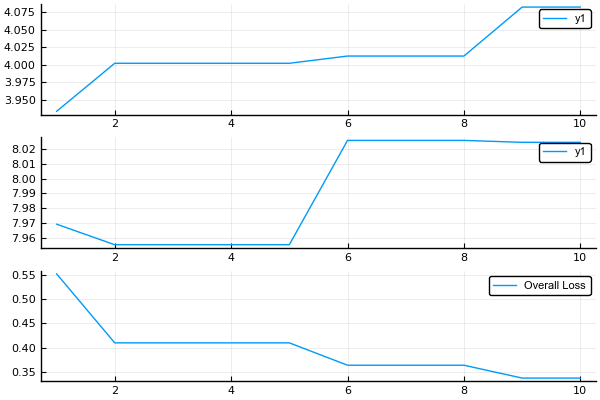

In [150]:
p1 = plot(dParLoss[(:τw |> p_find)[1], :])
p2 = plot(dParLoss[(:σ |> p_find)[1], :])
p_loss = plot(loss_record, label = "Overall Loss")
plot(p1, p2, p_loss, layout = grid(3,1))

In [143]:
optimal_p = optimal_sim.p
keys = Tuple(BurstModel.params)
opt_p = NamedTuple{keys}(optimal_p);
write_JSON(opt_p, "optimal_pars.json")

768

In [151]:
p_dict = read_JSON("optimal_pars.json", is_type = Dict{Symbol, Float64});
u_dict = read_JSON("conds.json", is_type = Dict{Symbol, Float64});

#p_dict[:ρ] = 0.5
#p_dict[:D] = 0.01
#p_dict[:k_d] = 0.04
#p_dict[:g_ACh] = 1.0

pi = extract_dict(p_dict, BurstModel.params);
println(u_dict)
u0 = extract_dict(u_dict, BurstModel.syms);
tspan = (0.0, 300e3);

Dict(:a => 0.5,:b => 0.5,:n => 0.0,:ACh => 0.0,:v => -60.0,:W => 0.0,:c => 0.085)


In [152]:
prob = SDEProblem(BurstModel, noise, u0, tspan, pi)
println("Time it took to simulate 200ms:")
@time sol = solve(prob, SOSRA(), abstol = 2e-1, reltol = 2e-1, maxiter = 1e7, saveat = dt_sim);

Time it took to simulate 200ms:
  2.975300 seconds (2.67 M allocations: 95.108 MiB, 73.36% gc time)


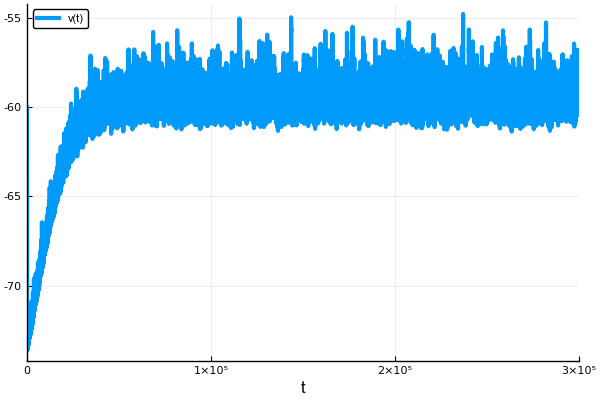

In [153]:
plot(sol, vars = [:v])

1.4207145655349247


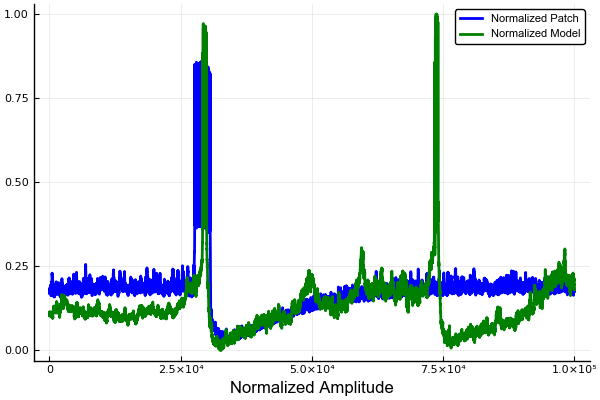

In [120]:
Ŷ = map(t -> sol(t)[1], sol.t)
old_rng = (minimum(Y), maximum(Y))
Ŷ_norm = Ŷ |> x -> normalize(x; old_rng = old_rng)
min_loss, lag = lagged_loss(Ŷ_norm, Y_norm; weights = [1, 1])
i = lag
println(min_loss)
fit_rng = Int.(collect(lag:(100e3+lag-1)))
p = plot()
plot!(p, Ŷ_norm[fit_rng], c = :blue, lw = :2.0, label = "Normalized Patch")
plot!(p, Y_norm, c = :green, lw = :2.0, label = "Normalized Model",
#    xlims = xlims, xticks = xticks
)
xlabel!(p, "Normalized Amplitude")

In [121]:
fold_change = zeros(length(optimal_p))
for (idx, val) in enumerate(optimal_sim.p)
    fold_change[idx] = val/p0[idx]
    println("$(BurstModel.params[idx]) = $(val)")
end

g_leak = 1.99519244290093
E_leak = -68.891088842849
g_Ca = 9.718417954506501
V1 = -19.453812642032336
V2 = 19.86455396831743
E_Ca = 40.23030537330822
g_K = 5.057377165576645
E_K = -92.48336607789155
g_TREK = 2.050733984056828
g_ACh = 1.056957521545357
k_d = 0.04893778529232928
E_ACh = 0.0
I_app = 0.0
C_m = 22.607297071696276
V3 = -25.93797904342085
V4 = 6.739674663778372
τn = 4.938533206493982
C_0 = 0.0908570423758191
λ = 2.6737931874651357
δ = 0.010618614178235172
τc = 1975.3885037992036
α = 61.662722909415606
τa = 8086.684734334368
β = 4.312767143698622
τb = 8409.930336748375
ρ = 0.040162029867567825
τACh = 541.0474231486772
k = 0.1976337426348073
V0 = -40.1571704056911
σ = 7.9043119301373315
D = 0.009552274883724033
τw = 4.148955413768669


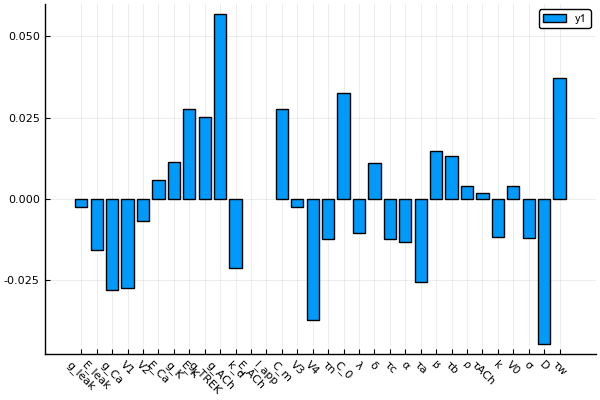

In [123]:
bar(fold_change .- 1.0, xticks = (1:length(BurstModel.params), BurstModel.params), xrotation=-45)

In [ ]:
#d0 = extract_dict(d_dict, par);
#prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = [par], par_range = p_range)
d0 = extract_dict(d_dict, BurstModel.params);
prob_func(prob, i, repeat) = monte_func(prob, i, repeat; pars = par, dists = d0)

In [ ]:
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
@time sim = solve(ensemble_prob, SRIW1(), saveat = dt_sim, maxiters = 1e7, trajectories = n_sims, EnsembleThreads());

In [ ]:
histogram(losses)

In [ ]:
#p_rng1 = map(traj -> traj.prob.p[(par[1] |> p_find)[1]], sim[:]);
#plot(p_rng1, losses, seriestype = :scatter)

In [ ]:
p_rng1 = map(traj -> traj.prob.p[(par[1] |> p_find)[1]], sim[:]);
p_rng2 = map(traj -> traj.prob.p[(par[2] |> p_find)[1]], sim[:]);

In [ ]:
over_loss = findall(x -> x > min_loss, losses)
under_loss = findall(x -> x < min_loss, losses)
plot(p_rng1, p_rng2, losses, 
    seriestype = :scatter, c = :red, 
    xlabel = par[1], ylabel = par[2], zlabel = "Loss")

In [ ]:
opt_p1 = sim[argmin(losses)].prob.p[(par[1] |> p_find)[1]]
opt_p2 = sim[argmin(losses)].prob.p[(par[2] |> p_find)[1]]
println(opt_p1, opt_p2)

In [ ]:
p = plot()
for (idx, traj) in enumerate(sim)
    Ŷ = map(t -> traj(t)[1], traj.t)
    f_norm(x) = normalize(x; old_rng = old_rng)
    Ŷ_norm = Ŷ |> f_norm
    loss, lag = lagged_loss(Ŷ_norm, Y_norm)
    t_limited = LinRange(lag, lag+100e3-1, 500)
    vt = map(x -> traj(x)[1], t_limited)
    nt = map(x -> traj(x)[2], t_limited)
    z = repeat([p_rng[idx]], length(nt))
    plot!(p, z, vt, nt, line_z = loss, clims = (minimum(losses), maximum(losses)))
end
p

## Idea 1
Calculating mean squared error for a single time point

In [ ]:
#Our model should be warmed-up from above. ALl we have to do is save the endpoint
x_guess = @SArray [vm_sec[1], 0.0, 0.0, 0.0, 0.0, 0.0]
@time model = init_model(8000.0, params; wu_tmax = 0.0, initial_x = x_guess);
println("Running simulation for 60s:");
@time traj, data = model(alg = Rosenbrock23(), saveat = 10.0);

In [ ]:
plot(data)

In [ ]:
p_t0 = vm_sec[1]
s_t0 = traj[1][1]
p_t1 = vm_sec[Int(1.0/dt)]
s_t1 = traj[end][1]


println("Phys t0: $p_t0")
println("Sim t0: $s_t0")
println("Phys t1: $p_t1")
println("Sim t0: $s_t1")

In [ ]:
#Making mean squared error loss function
LpNORM(x, p) = sum(x.^p)^(1/p) #This is a basic normalization of the data
L2NORM(x) = LpNORM(x, 2) #This is the typical L2 Normalizations
MSE(Ȳ, Y) = L2NORM(Ȳ - Y)/(length(Ȳ))

In [ ]:
"""
This function utilizes monte carlo simulations to stepwise optimize our model. 
"""
to_optimize = ["alpha", "beta", "tau_B", "tau_A"]
function param_optimizer(data, params; step_size = 100.0, dt = 5e-5, n_sims = 100, pars_to_opt = to_optimize, verbose = true)
    @assert step_size > dt
    n_steps = data |> length
    v_i = data[1] #This begins the initial simulated point. Each simulation begins here
    
    #define initial conditions
    xᵢ = [v_i, 0.0, 0.0, 0.0, 0.0, 0.0]
    θᵢ = copy(params) 
    lossᵢ = Inf
    for i = 1:step_size:n_steps-step_size
        xᵢ[1] = v_i
        model = init_model(i, θᵢ; wu_tmax = 0.0, initial_x = xᵢ)
        sol, _ = model(alg = Rosenbrock23(), save_everystep = false)
        lossᵢ = MSE(data[Int(i/dt)], sol[end][1])
         
        #println("Initial loss = $lossᵢ") 
                             
        for sim = 1:n_sims
            #Randomize initial points
            x₀ = xᵢ#map(x -> x>=0 ? rand(truncated(Normal(x), 0, 1)) : x, xᵢ)
            θ₀ = copy(θᵢ);
            #Randomize parameters
            for p in θᵢ
                if (findall(x -> x == p[1], pars_to_opt) |> length) <= 0
                    if p[2] > 0
                        θ₀[p[1]] = rand(Gamma(p[2]))
                    else
                        θ₀[p[1]] = rand(Normal(p[2]))
                    end
                else
                    θ₀[p[1]] = p[2]
                end
            end
            
            #Calculate the loss on the model
            model = init_model(i, θ₀; wu_tmax = 0.0, initial_x = x₀)
            sol, _ = model(alg = Rosenbrock23(), save_everystep = false)
            loss₀ = MSE(data[Int(i/dt)], sol[end][1])
            
            if loss₀ < lossᵢ
                #println("Loss has improved $loss₀") 
                lossᵢ = loss₀
                θᵢ = θ₀
                xᵢ = x₀                
            end
        end
        #println("Best loss of step $i: $lossᵢ") 
    end
    println("Optimal Loss: $lossᵢ")
    return θᵢ, xᵢ
end

In [ ]:
@time pars_opt, x_opt = param_optimizer(vm_sec, params)

In [ ]:
tmax = 120e3;
dt_model = 10.0
println("Warming model up:");
@time model= init_model(tmax, params; model = RetinalChaos.V1_Tarchick_1D, name = "Vector");
println("Running simulation for 60s:");
@time traj, data = model(alg = Rosenbrock23(), saveat = dt_model);

In [ ]:
plot(data)

In [ ]:
using Distributions

### Bayesian Model Estimation

In [ ]:
f1 = @ode_def begin
  dx = a*x - b*x*y
  dy = -c*y + d*x*y
    end a b c d;

In [ ]:
p_tru = [1.5,1.0,3.0,1.0];
p = rand(4)
u0 = [1.0,1.0];
tspan = (0.0,10.0);
prob1 = ODEProblem(f1,u0,tspan,p);
sol = solve(prob1,Tsit5());

In [ ]:
σ = 0.01 ;                        # noise, fixed for now
t = collect(range(1,stop=10,length=10)); # observation times

In [ ]:
#randomized = VectorOfArray([(sol(t[i]) + σ * randn(2)) for i in 1:length(t)]);
#data = convert(Array,randomized);

In [ ]:
plot(sol)
plot!(data', seriestype = :scatter)

In [ ]:
#priors = [Gamma(p[1],0.1),truncated(Normal(p[2],0.1),0,1.5),
#          truncated(Normal(p[3],0.1),0,4),truncated(Normal(p[4],0.1),0,2)];
priors = [Gamma(p[1]),Gamma(p[2]), Gamma(p[3]), Gamma(p[4])];

In [ ]:
println("True parameters : $p_tru")
println("Initial Parameters : $p")
result_abc = abc_inference(prob1, Tsit5(), t, data, priors;
                                num_samples=1000, ϵ = 0.001);

p_opt = mean(result_abc.parameters, weights(result_abc.weights), dims = 1)

In [ ]:
plot(sol)
plot!(sol_opt)
plot!(data', seriestype = :scatter)

In [ ]:
g_leak = 2.0
E_leak = -70.0

g_Ca = 10.0
E_Ca = 40.0
V1 = -20.0
V2 = 20.0

g_K = 7.0
E_K = -90.0
V3 = -25.0
V4 = 7.0 
τn = 5.0 

C_0 = 88.0
λ = 2.702
δ = 10.503
τc = 2000.0


I_app = 0.0;
C_m = 22.0;
α  = 6.25e-10
β = 4.25
τa = 8300.0;
τb = 8300.0;
g_sAHP = 2.0

ρ = 1.0
τACh = 200.0
κ = 0.2
V0 = -40.0

In [ ]:
minf(v::T where T, V_1::T where T, V_2::T where T) = (1 + tanh((v - V_1)/V_2))/2
ninf(v::T where T, V_3::T where T, V_4::T where T) = (1 + tanh((v - V_3)/V_4))/2
Φ(v::T where T, κ::T where T, V_0::T where T)     = 1/(1 + exp(-κ * (v - V_0)))
Λ(v::T where T, V_3::T where T, V_4::T where T)   = cosh((v - V_3)/(2 * V_4))

In [ ]:
full_model = @ode_def begin
    dv = ((-g_leak * (v - E_leak)) + (-g_Ca * minf(v, V1, V2) * (v - E_Ca)) + (-g_K * n * (v - E_K)) + (-g_sAHP * b * (v - E_K)) + I_app)/C_m
    dn = (Λ(v, V3, V4) * ((ninf(v, V3, V4) - n)))/τn
    dc = (C_0 + δ*(-g_Ca * minf(v, V1, V2)* (v - E_Ca)) - λ*c)/τc
    da =  (α*c^4*(1-a) - a)/τa
    db =  (β*a^4*(1-b) - b)/τb
    dACh = (ρ*Φ(v, κ, V0) - ACh)/τACh
end g_leak E_leak g_Ca E_Ca V1 V2 g_K E_K V3 V4 τn g_sAHP I_app C_m  C_0 λ δ τc α τa β τb κ V0 ρ τACh;

In [ ]:
#Define the white noise process
g()

In [ ]:
u0 = [-70.0, 0.0, 0.0, 0.0, 0.0, 0.0];
pars = [g_leak, E_leak, g_Ca, E_Ca, V1, V2,  g_K, E_K, V3, V4, τn, g_sAHP, I_app, C_m,  C_0, λ, δ, τc, α, τa, β, τb, κ, V0, ρ, τACh];
tspan = (0.0, 30e3);
prob = ODEProblem(secondary_model, u0, tspan, pars);
println("Time it took to simulate 200ms:")
@time sol = solve(prob);

In [ ]:
plot(sol, vars = [:v, :n, :c, :a, :b, :ACh], layout = grid(6, 1), size = (1000, 750))

In [ ]:
u0 = [-70.0, 0.0, 0.0, 0.0, 0.0, 0.0];
pars = [g_leak, E_leak, g_Ca, E_Ca, V1, V2,  g_K, E_K, V3, V4, τn, g_sAHP, I_app, C_m,  C_0, λ, δ, τc, α, τa, β, τb, κ, V0, ρ, τACh];
tspan = (0.0, 30e3);
prob = RODEProblem(secondary_model, u0, tspan, pars);
println("Time it took to simulate 200ms:")
@time sol = solve(prob);

#### We can use a combination of Principal Component analysis and Particle Swarm Analysis to optimize the parameters
#### We can define the basic L2Norm and MeanSquaredError (MSE) loss functions 

In [ ]:
#These are our loss functions 
LpNORM(x, p) = sum(x.^p)^(1/p) #This is a basic normalization of the data
L2NORM(x) = LpNORM(x, 2) #This is the typical L2 Normalizations
MSE(Ȳ, Y) = L2NORM(Ȳ - Y)/(length(Ȳ))

#### We implement the loss function we have constructed ourselves

In [ ]:
#This is a more detailed aggregate loss function
function loss_func(ȳ, y) 
    v̄ = ȳ.trace_mat[:, 1];
    c̄ = ȳ.trace_mat[:, 5];
    ā = ȳ.trace_mat[:, 3];
    b̄ = ȳ.trace_mat[:, 4];
    mse_v = MSE(v̄, y[1,:])       * 1
    mse_c = MSE(c̄, y[3,:])       * 1/6
    mse_a = MSE(ā, 1 .- y[26,:]) * 100  #a represents the ratio of cAMP gen/decay, so it is inverse
    mse_b = MSE(b̄, y[33,:])      * 100  #b is related to TREK amount
    #We add magnitudes to each mean squared error, because a and b are just as important as v and c
    
    #println("Loss = ($mse_v, $mse_c, $mse_a, $mse_b)")
    mse_v + mse_c + mse_a + mse_b
end

losses(sim) = map(x -> loss_func(data, x), sim[:])
mean_loss(sim) = sum(losses(sim))/length(sim)
min_loss(sim) = sim |> losses |> minimum 

###### First we construct an Ensemble (Monte Carlo) problem and simulate 100 trajectories

In [ ]:
using DiffEqParamEstim, Optim
using MultivariateStats, RDatasets, Plots

In [ ]:
M = fit(PCA, xtr, maxoutdim = 2)